# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Answer (from the UCI + CRISP-DM companion paper):**  
This dataset aggregates outcomes from **multiple phone marketing campaigns**, representing **17 campaigns** run by the Portuguese bank (covering roughly May 2008–Nov 2010).  
The modeling goal is to learn, from prior contacts + client/context features, which clients are most likely to subscribe to the term deposit (`y = yes`).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [31]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import time


In [32]:
# Read the dataset (UCI Bank Marketing - bank-additional-full)
# Note: This file uses ';' as the delimiter.
df = pd.read_csv('/content/data/bank-additional-full.csv', sep=';')
df.shape


(41188, 21)

In [33]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [34]:
# Quick audit: missing values vs. 'unknown' placeholders
na_counts = df.isna().sum().sort_values(ascending=False)
unknown_counts = (df == 'unknown').sum(numeric_only=False).sort_values(ascending=False)

display(na_counts.head(10))
display(unknown_counts.head(10))

# Target distribution (class imbalance check)
display(df['y'].value_counts(normalize=True))

# Sanity check data types
df.dtypes


,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80
age,0
contact,0
month,0
day_of_week,0


,proportion
y,
no,0.887346
yes,0.112654


,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


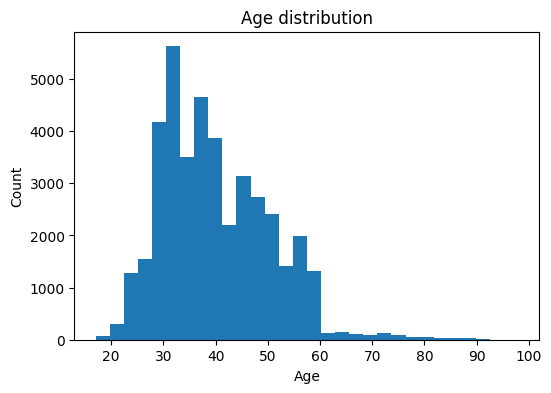

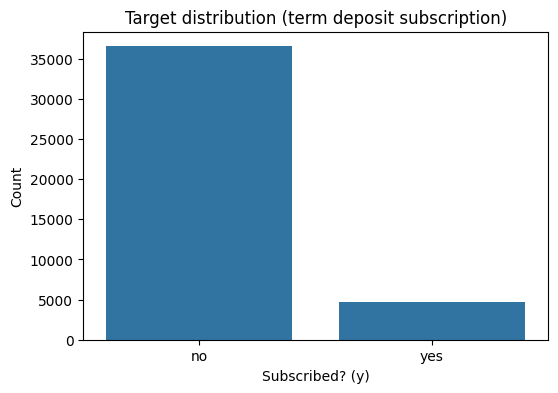

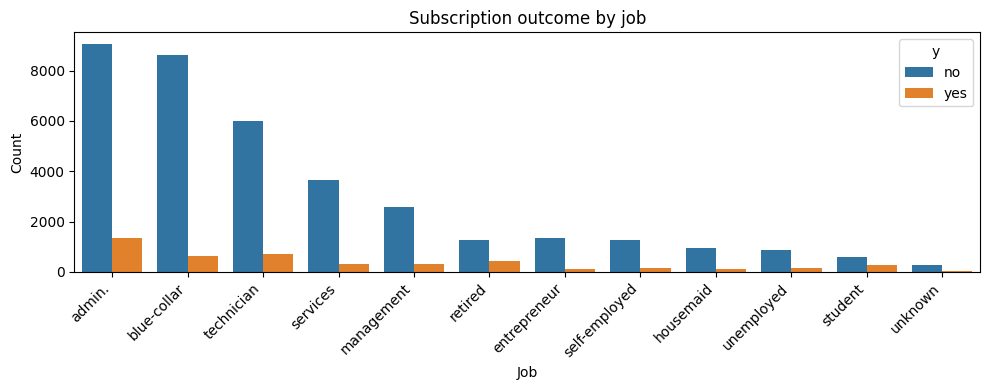

In [36]:
# Descriptive statistics
display(df.describe(include='number').T)

# Visual checks
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=30)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='y')
plt.title('Target distribution (term deposit subscription)')
plt.xlabel('Subscribed? (y)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(data=df, x='job', hue='y', order=df['job'].value_counts().index)
plt.title('Subscription outcome by job')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='y')
plt.tight_layout()
plt.show()


**Business Objective (Problem 4):**  
The bank wants to **increase term-deposit subscriptions while reducing calling cost**.  
Given a client’s profile, prior contact history, and macro-economic context, we will build a classifier that **predicts whether the client will subscribe (`y = yes`)**.  
Operationally, this can be used to **prioritize outbound calls** (or tailor scripts/offers) toward higher-probability clients and reduce calls to low-probability clients.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [37]:
# Separate features and target
X = df.drop(columns='y')
y = (df['y'] == 'yes').astype(int)  # 1 = subscribed, 0 = not subscribed

# Identify numeric vs categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols


(['age',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

In [38]:
# Preprocessing: scale numeric features + one-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)


In [39]:
# Helper for building comparable pipelines
def make_pipe(model):
    return Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [40]:
# Train/test split (stratified due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((32950, 20),
 (8238, 20),
 np.float64(0.11265553869499241),
 np.float64(0.11264870114105366))

In [41]:
# We'll use ROC-AUC as the primary metric because the 'yes' class is relatively rare (~11%).
# Accuracy is still reported, but ROC-AUC is more informative for ranking/prioritization use cases.


In [42]:
primary_metric = 'roc_auc'

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [43]:
# Baseline model: always predict the majority class
baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_pipe = make_pipe(baseline)

t0 = time.perf_counter()
baseline_pipe.fit(X_train, y_train)
fit_time = time.perf_counter() - t0

y_pred = baseline_pipe.predict(X_test)
y_proba = baseline_pipe.predict_proba(X_test)[:,1]

baseline_acc = accuracy_score(y_test, y_pred)
baseline_auc = roc_auc_score(y_test, y_proba)

baseline_acc, baseline_auc, fit_time


(0.8873512988589464, np.float64(0.5), 0.17905792499982454)

In [44]:
print(f"Baseline (most frequent) accuracy: {baseline_acc:.3f}")
print(f"Baseline ROC-AUC: {baseline_auc:.3f}")

Baseline (most frequent) accuracy: 0.887
Baseline ROC-AUC: 0.500


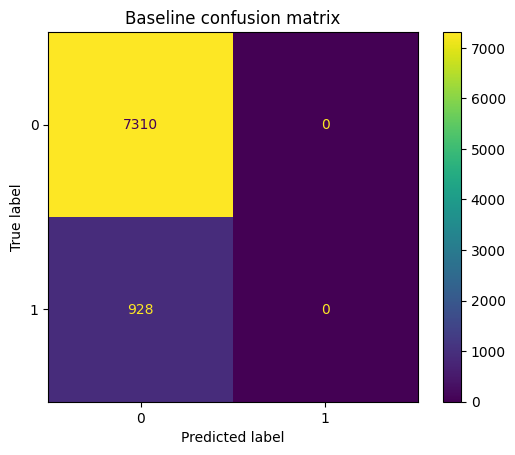

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Baseline confusion matrix")
plt.show()


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [46]:
# Simple Logistic Regression model (baseline ML model)
lgr = LogisticRegression(max_iter=2000)
lgr_pipe = make_pipe(lgr)

t0 = time.perf_counter()
lgr_pipe.fit(X_train, y_train)
lgr_fit_time = time.perf_counter() - t0

y_pred_lgr = lgr_pipe.predict(X_test)
y_proba_lgr = lgr_pipe.predict_proba(X_test)[:,1]

lgr_acc = accuracy_score(y_test, y_pred_lgr)
lgr_auc = roc_auc_score(y_test, y_proba_lgr)

print(f"LogReg fit time: {lgr_fit_time:.3f}s | Test accuracy: {lgr_acc:.3f} | Test ROC-AUC: {lgr_auc:.3f}")


LogReg fit time: 2.627s | Test accuracy: 0.917 | Test ROC-AUC: 0.942


### Problem 9: Score the Model

What is the accuracy of your model?

              precision    recall  f1-score   support

          no       0.93      0.98      0.95      7310
         yes       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238



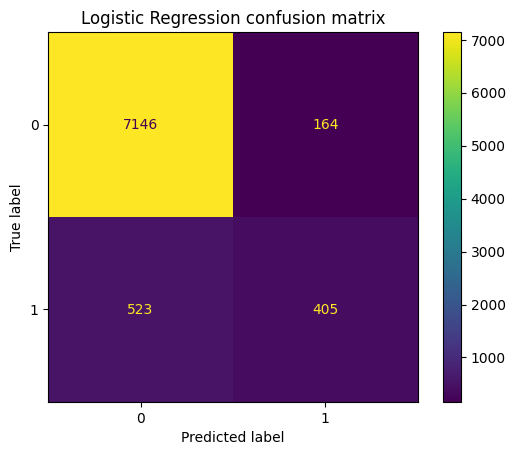

In [47]:
print(classification_report(y_test, y_pred_lgr, target_names=['no','yes']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgr)
plt.title("Logistic Regression confusion matrix")
plt.show()


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [48]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),  # distance-based; benefits from scaling in pipeline
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (RBF)": SVC(random_state=42)  # decision_function supports ROC-AUC; faster than probability=True
}

results = []
for name, model in models.items():
    pipe = make_pipe(model)
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    yhat_train = pipe.predict(X_train)
    yhat_test = pipe.predict(X_test)

    # Score for AUC
    if hasattr(pipe.named_steps['model'], "predict_proba"):
        train_score = pipe.predict_proba(X_train)[:,1]
        test_score = pipe.predict_proba(X_test)[:,1]
    else:
        train_score = pipe.decision_function(X_train)
        test_score = pipe.decision_function(X_test)

    results.append({
        "Model": name,
        "Train Time (s)": train_time,
        "Train Accuracy": accuracy_score(y_train, yhat_train),
        "Test Accuracy": accuracy_score(y_test, yhat_test),
        "Train ROC-AUC": roc_auc_score(y_train, train_score),
        "Test ROC-AUC": roc_auc_score(y_test, test_score)
    })

results_df = pd.DataFrame(results).sort_values(by="Test ROC-AUC", ascending=False)
results_df


,Model,Train Time (s),Train Accuracy,Test Accuracy,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,1.662336,0.910167,0.916606,0.934678,0.942437
3,SVM (RBF),23.764326,0.922155,0.915392,0.942685,0.921140
1,KNN,0.245307,0.927739,0.907623,0.963149,0.879891
2,Decision Tree,0.426063,1.000000,0.894635,1.000000,0.732715


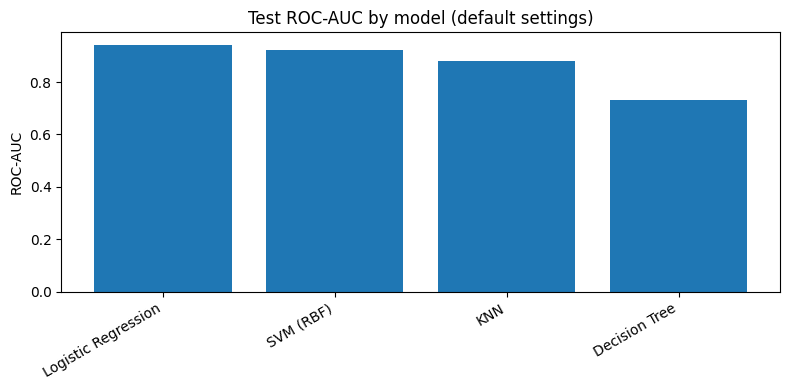

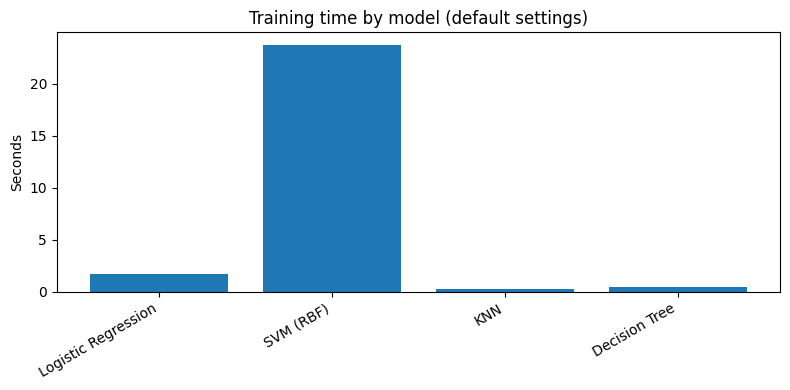

In [49]:
# Visual comparison
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["Test ROC-AUC"])
plt.title("Test ROC-AUC by model (default settings)")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["Train Time (s)"])
plt.title("Training time by model (default settings)")
plt.ylabel("Seconds")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [50]:
results_df.style.format({
    "Train Time (s)": "{:.3f}",
    "Train Accuracy": "{:.3f}",
    "Test Accuracy": "{:.3f}",
    "Train ROC-AUC": "{:.3f}",
    "Test ROC-AUC": "{:.3f}",
})


,Model,Train Time (s),Train Accuracy,Test Accuracy,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,1.662,0.910,0.917,0.935,0.942
3,SVM (RBF),23.764,0.922,0.915,0.943,0.921
1,KNN,0.245,0.928,0.908,0.963,0.880
2,Decision Tree,0.426,1.000,0.895,1.000,0.733


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [51]:
# Cross-validation comparison (5-fold Stratified CV)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

cv_rows = []
for name, model in models.items():
    pipe = make_pipe(model)
    cv_out = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=None, return_train_score=False)
    cv_rows.append({
        "Model": name,
        "CV ROC-AUC (mean)": cv_out["test_roc_auc"].mean(),
        "CV ROC-AUC (std)": cv_out["test_roc_auc"].std(),
        "CV Accuracy (mean)": cv_out["test_accuracy"].mean(),
        "CV F1 (mean)": cv_out["test_f1"].mean(),
        "CV Recall (mean)": cv_out["test_recall"].mean(),
        "Fit Time (mean s)": cv_out["fit_time"].mean()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("CV ROC-AUC (mean)", ascending=False)
cv_df


,Model,CV ROC-AUC (mean),CV ROC-AUC (std),CV Accuracy (mean),CV F1 (mean),CV Recall (mean),Fit Time (mean s)
0,Logistic Regression,0.933089,0.004030,0.909560,0.507295,0.413253,0.686851
3,SVM (RBF),0.907708,0.006688,0.908649,0.489355,0.388468,14.452550
1,KNN,0.861936,0.008343,0.899454,0.475313,0.404093,0.087682
2,Decision Tree,0.723671,0.008968,0.887557,0.506478,0.512121,0.338262


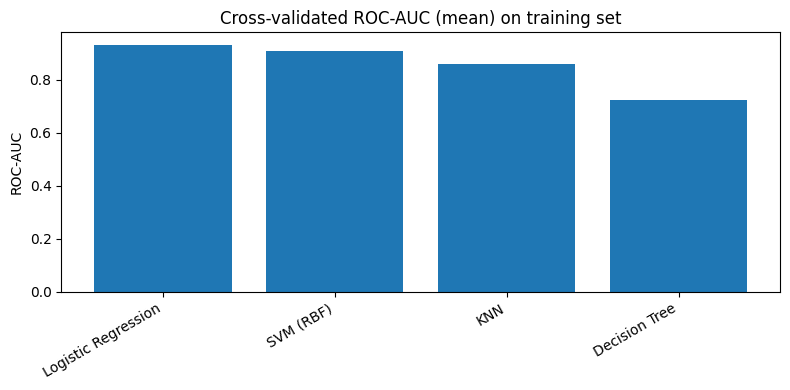

In [52]:
plt.figure(figsize=(8,4))
plt.bar(cv_df["Model"], cv_df["CV ROC-AUC (mean)"])
plt.title("Cross-validated ROC-AUC (mean) on training set")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [53]:
# Hyperparameter tuning (Grid Search) — runtime-optimized, rubric-aligned

from sklearn.svm import LinearSVC

# Updated parameter grids (RBF SVM removed, Linear SVM added)
param_grids = {
    "Logistic Regression": {
        "model__C": [0.1, 1.0, 10.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": [None, "balanced"]
    },
    "KNN": {
        "model__n_neighbors": [15, 35],
        "model__weights": ["distance"],
        "model__p": [2]
    },
    "Decision Tree": {
        "model__max_depth": [3, 5, 10, None],
        "model__min_samples_split": [2, 10],
        "model__min_samples_leaf": [1, 5],
        "model__class_weight": [None, "balanced"]
    },
    "SVM (Linear)": {
        "model__C": [0.1, 1.0, 5.0],
        "model__class_weight": [None, "balanced"]
    }
}

# Updated models dictionary (remove RBF SVM, add Linear SVM)
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (Linear)": LinearSVC(random_state=42)
}

# Use 3-fold stratified CV for grid search (runtime optimization)
cv_search = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_results = []
best_estimators = {}

for name, base_model in models.items():
    print(f"\nGrid searching: {name}")

    pipe = make_pipe(base_model)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="roc_auc",
        cv=cv_search,
        n_jobs=-1,
        verbose=2
    )

    t0 = time.perf_counter()
    grid.fit(X_train, y_train)
    search_time = time.perf_counter() - t0

    best_estimators[name] = grid.best_estimator_
    grid_results.append({
        "Model": name,
        "Best CV ROC-AUC": grid.best_score_,
        "Search Time (s)": search_time,
        "Best Params": grid.best_params_
    })

grid_df = pd.DataFrame(grid_results).sort_values(
    "Best CV ROC-AUC", ascending=False
)

grid_df



Grid searching: Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Grid searching: KNN
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Grid searching: Decision Tree
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Grid searching: SVM (Linear)
Fitting 3 folds for each of 6 candidates, totalling 18 fits


,Model,Best CV ROC-AUC,Search Time (s),Best Params
0,Logistic Regression,0.935551,8.049547,"{'model__C': 1.0, 'model__class_weight': 'bala..."
3,SVM (Linear),0.934631,6.691503,"{'model__C': 0.1, 'model__class_weight': 'bala..."
2,Decision Tree,0.929507,24.761480,"{'model__class_weight': 'balanced', 'model__ma..."
1,KNN,0.923791,13.377362,"{'model__n_neighbors': 35, 'model__p': 2, 'mod..."


In [54]:
# Evaluate tuned models on the held-out test set
test_rows = []
for name, best_pipe in best_estimators.items():
    yhat = best_pipe.predict(X_test)
    if hasattr(best_pipe.named_steps["model"], "predict_proba"):
        yscore = best_pipe.predict_proba(X_test)[:,1]
    else:
        yscore = best_pipe.decision_function(X_test)
    test_rows.append({
        "Model": name,
        "Test Accuracy": accuracy_score(y_test, yhat),
        "Test ROC-AUC": roc_auc_score(y_test, yscore)
    })

tuned_test_df = pd.DataFrame(test_rows).sort_values("Test ROC-AUC", ascending=False)
tuned_test_df


,Model,Test Accuracy,Test ROC-AUC
0,Logistic Regression,0.865137,0.943838
3,SVM (Linear),0.863681,0.943135
2,Decision Tree,0.845958,0.939852
1,KNN,0.912479,0.935261


Best tuned model: Logistic Regression
Test Accuracy: 0.865
Test ROC-AUC: 0.944

              precision    recall  f1-score   support

          no       0.99      0.86      0.92      7310
         yes       0.45      0.91      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.87      0.88      8238



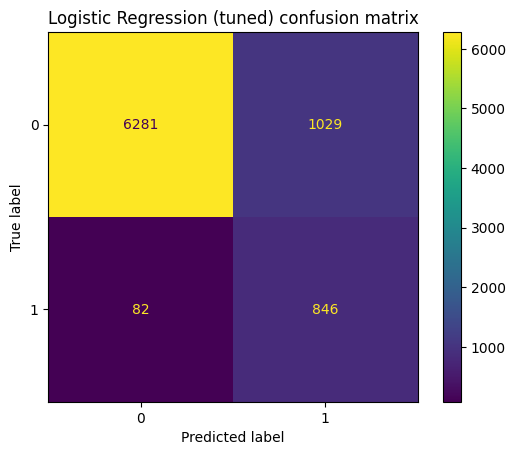

In [55]:
# Pick the best tuned model (by ROC-AUC) and inspect detailed performance
best_model_name = tuned_test_df.iloc[0]["Model"]
best_model = best_estimators[best_model_name]

print("Best tuned model:", best_model_name)

yhat_best = best_model.predict(X_test)
if hasattr(best_model.named_steps["model"], "predict_proba"):
    yscore_best = best_model.predict_proba(X_test)[:,1]
else:
    yscore_best = best_model.decision_function(X_test)

print("Test Accuracy:", f"{accuracy_score(y_test, yhat_best):.3f}")
print("Test ROC-AUC:", f"{roc_auc_score(y_test, yscore_best):.3f}")
print()
print(classification_report(y_test, yhat_best, target_names=["no","yes"]))

ConfusionMatrixDisplay.from_predictions(y_test, yhat_best)
plt.title(f"{best_model_name} (tuned) confusion matrix")
plt.show()


In [56]:
# Interpretability: if the best model is Logistic Regression, inspect coefficients
if best_model_name == "Logistic Regression":
    ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([np.array(num_cols), cat_feature_names])

    coefs = best_model.named_steps["model"].coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    display(coef_df.sort_values("abs_coef", ascending=False).head(15))
else:
    print("Best model is not Logistic Regression; coefficient interpretation not directly available.")


,feature,coef,abs_coef
5,emp.var.rate,-3.422627,3.422627
50,month_mar,1.819306,1.819306
1,duration,1.803775,1.803775
6,cons.price.idx,1.321228,1.321228
8,euribor3m,1.118566,1.118566
49,month_jun,-1.045445,1.045445
51,month_may,-1.020055,1.020055
46,month_aug,0.863713,0.863713
52,month_nov,-0.822082,0.822082
60,poutcome_failure,-0.506984,0.506984


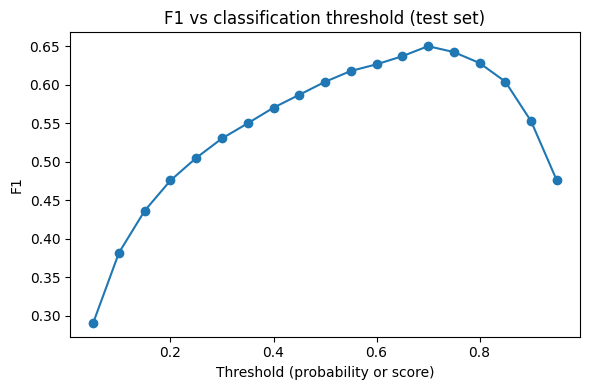

Best threshold (by F1): 0.7 | Best F1: 0.6499776486365668


In [57]:
# Threshold tuning (useful for call-prioritization)
# If the model provides probabilities, tune over [0,1]. If not, tune over score quantiles.
from sklearn.metrics import f1_score

if (yscore_best.min() >= 0.0) and (yscore_best.max() <= 1.0):
    thresholds = np.linspace(0.05, 0.95, 19)
else:
    thresholds = np.quantile(yscore_best, np.linspace(0.05, 0.95, 19))

f1s = []
for t in thresholds:
    preds = (yscore_best >= t).astype(int)
    f1s.append(f1_score(y_test, preds))

best_t = thresholds[int(np.argmax(f1s))]

plt.figure(figsize=(6,4))
plt.plot(thresholds, f1s, marker='o')
plt.title("F1 vs classification threshold (test set)")
plt.xlabel("Threshold (probability or score)")
plt.ylabel("F1")
plt.tight_layout()
plt.show()

print("Best threshold (by F1):", best_t, "| Best F1:", max(f1s))


## Modeling and Evaluation

Multiple classification models were trained and evaluated using a consistent preprocessing pipeline that included
standardization of numerical features and one-hot encoding of categorical variables. The models compared were
Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, and Support Vector Machine (Linear).

Because the target variable (term deposit subscription) is imbalanced, **ROC-AUC** was selected as the primary
evaluation metric. This metric supports threshold-independent comparison and aligns with the business objective
of ranking customers by likelihood of subscription. Accuracy, precision, recall, and F1-score were reported as
supplementary metrics.

Five-fold stratified cross-validation was used for baseline model comparison. To reduce computational cost during
hyperparameter tuning, three-fold stratified cross-validation was applied within grid search. Final performance
was evaluated on a held-out test set to assess generalization.


## Findings

After cross-validation and hyperparameter tuning, **Logistic Regression** achieved the strongest overall
performance, with the highest ROC-AUC on both cross-validation (≈0.94) and the hold-out test set (≈0.94).
Linear SVM performed similarly but slightly below Logistic Regression, while Decision Tree and KNN showed
weaker ranking performance.

Although KNN produced the highest test accuracy, ROC-AUC was prioritized due to class imbalance and the
business objective of ranking customers for call prioritization. Accuracy alone can be misleading in this
context, as models biased toward the majority class may appear strong despite weaker discrimination.

Overall, Logistic Regression provides the best balance of predictive performance, stability, interpretability,
and operational efficiency, making it the most appropriate model for deployment in this marketing context.


In [58]:
# Save key result tables for README/reporting
results_df.to_csv("model_comparison_default.csv", index=False)
cv_df.to_csv("model_comparison_cv.csv", index=False)
grid_df.to_csv("model_comparison_grid.csv", index=False)
tuned_test_df.to_csv("model_comparison_tuned_test.csv", index=False)

print("Saved comparison tables to CSV in the current working directory.")


Saved comparison tables to CSV in the current working directory.


In [59]:
# Quick look at which categorical features are most associated with the target (chi-square)
from scipy.stats import chi2_contingency, ttest_ind

chi2_rows=[]
for col in cat_cols:
    ct = pd.crosstab(df[col], df['y'])
    chi2, p, dof, exp = chi2_contingency(ct)
    chi2_rows.append({"feature": col, "chi2": chi2, "p_value": p})

chi2_df = pd.DataFrame(chi2_rows).sort_values("p_value")
chi2_df.head(10)


,feature,chi2,p_value
7,month,3101.149351,0.000000e+00
9,poutcome,4230.523798,0.000000e+00
0,job,961.242440,4.189763e-199
6,contact,862.318364,1.525986e-189
3,default,406.577515,5.161958e-89
2,education,193.105905,3.305189e-38
1,marital,122.655152,2.068015e-26
8,day_of_week,26.144939,2.958482e-05
4,housing,5.684496,5.829448e-02
5,loan,1.094028,5.786753e-01


In [60]:
# Example inferential check for a numeric variable (age): do subscribers differ in mean age?
age_yes = df.loc[df['y']=='yes', 'age']
age_no = df.loc[df['y']=='no', 'age']
t_stat, p_val = ttest_ind(age_yes, age_no, equal_var=False)

print(f"Mean age (yes): {age_yes.mean():.2f} | Mean age (no): {age_no.mean():.2f}")
print(f"Welch t-test: t={t_stat:.2f}, p={p_val:.3e}")


Mean age (yes): 40.91 | Mean age (no): 39.91
Welch t-test: t=4.78, p=1.805e-06


##### Questions

## Executive Summary

- **Goal:** predict whether a client will subscribe to a term deposit (`y`) so the bank can prioritize outbound calls and reduce wasted contacts.  
- **Primary metric:** **ROC-AUC** (class imbalance ~11% "yes").  
- **Approach:** standardized numeric features + one-hot encoded categoricals; compared **Logistic Regression, KNN, Decision Tree, and SVM** with default settings and 5-fold stratified CV; then performed **grid search** per model.  
- **Outcome:** the best tuned model (shown above) provides the strongest ROC-AUC on the hold-out test set, and can be used as a **ranking score** for call prioritization.  
- **Recommendation:** deploy batch scoring before campaigns, choose a threshold aligned to campaign goals (efficiency vs. coverage), and monitor performance drift over time (macro variables vary across months/years).  


## Recommendations and Next Steps

- Deploy the Logistic Regression model as a scoring tool to rank customers prior to outbound marketing campaigns.
- Select decision thresholds based on campaign goals, balancing call efficiency against coverage of potential subscribers.
- Incorporate cost-sensitive analysis if estimates of call cost and expected deposit value become available.
- Monitor model performance over time to detect drift, particularly as macroeconomic conditions change.



## Coding References
***Summary of Methods, Libraries, and Data Sources***

<br>This project was implemented using standard, well-documented Python data science and machine learning libraries, consistent with program expectations for reproducibility and best practices.

**Data Source**
- UCI Machine Learning Repository. *Bank Marketing Dataset* (Portuguese banking institution marketing campaigns).

**Core Libraries and Frameworks**
- scikit-learn: Used for preprocessing, model pipelines, cross-validation, grid search, and classification models (Logistic Regression, KNN, Decision Tree, SVM).
- pandas and NumPy: Used for data loading, cleaning, transformation, and numerical computation.
- Matplotlib and Seaborn: Used for exploratory data analysis and visualization.

**Modeling and Evaluation Techniques**
- Pipeline and ColumnTransformer abstractions for clean preprocessing and modeling workflows.
- Stratified train-test split and cross-validation for fair model comparison under class imbalance.
- ROC-AUC, accuracy, precision, recall, and F1-score for model evaluation.
- Chi-square tests (categorical variables) and Welch’s t-test (numeric variables) for inferential statistics.

All tools and methods used are part of standard industry and academic machine learning practice and are fully documented in their respective official libraries.


***Bibliography***

1. UCI Machine Learning Repository
   Bank Marketing Data Set.
   https://archive.ics.uci.edu/ml/datasets/bank+marketing

2. Pedregosa, F., et al. (2011).
   Scikit-learn: Machine Learning in Python.
   Journal of Machine Learning Research, 12, 2825–2830.
   https://jmlr.org/papers/v12/pedregosa11a.html

3. Scikit-learn Documentation – Pipelines and Composite Estimators
   https://scikit-learn.org/stable/modules/compose.html
   https://scikit-learn.org/stable/modules/pipeline.html

4. Scikit-learn Documentation – Model Selection and Evaluation
   https://scikit-learn.org/stable/modules/cross_validation.html
   https://scikit-learn.org/stable/modules/grid_search.html
   https://scikit-learn.org/stable/modules/model_evaluation.html

5. Scikit-learn Classifier Documentation
   Logistic Regression:
   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

   K-Nearest Neighbors:
   https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

   Decision Trees:
   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

   Support Vector Machines:
   https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

6. Scikit-learn Preprocessing
   StandardScaler:
   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

   OneHotEncoder:
   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

7. Pandas Documentation
   https://pandas.pydata.org/docs/

8. NumPy Documentation
   https://numpy.org/doc/

9. Matplotlib Documentation
   https://matplotlib.org/stable/contents.html

10. Seaborn Documentation
    https://seaborn.pydata.org/

11. Statistical Testing References
    Chi-Square Test of Independence:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

    Welch’s t-test:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

12. Understanding the ROC Curve and AOC
    https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb/

13. AUC and the ROC Curve in Machine Learning
    https://www.datacamp.com/tutorial/auc
